In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from shapely.geometry import Point
import pandas as pd
import numpy as np
import os
import glob
import geopandas as gpd
import sys
import cartopy.crs as ccrs
import json
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
from ipv_workbench.utilities import utils
# from ipv_workbench.translators import panelizer

if sys.platform == 'win32':
    project_root = r'C:\\Users'
else:
    project_root = '/Users/jmccarty/GitHub/cmip6_and_buildings'
    
cz_list = ['1a','2a','2b','3a','3b','3bc','3c','4a',
           '4b', '4c','5a','5b','6a','6b','7a','8a']

cz_names = {'1a':'Very Hot Humid',
            '2a':'Hot Humid',
            '2b':'Hot Dry',
            '3a':'Warm Humid',
            '3b':'Warm Dry',
            '3bc':'Warm Dry Marine',
            '3c':'Warm Marine',
            '4a':'Mixed Humid',
            '4b':'Mixed Dry',
            '4c':'Mixed Marine',
            '5a':'Cool Humid',
            '5b':'Cold Dry',
            '5c':'Cool Marine',
            '6a':'Cold Humid',
            '6b':'Cold Dry',
            '7a':'Very Cold',
            '8a':'Subarctic/Arctic'}

cz_color_dict = {}
with open('./input_data/IECC Climate Zones Colors.json','r') as json_file:
    data = json.load(json_file)
for entry in data['colors']:
    zone_code = entry['zone']
    cz_color_dict[zone_code] = entry['hex']

In [3]:
# load up the emissions data for the USA
us_emissions = glob.glob(os.path.join("/Users/jmccarty/GitHub/grid_carbon_data/open_grid/2019_carbon_accounting_hourly_metric_units","*.csv"))
ba_data = pd.read_excel("/Users/jmccarty/GitHub/grid_carbon_data/open_grid/EIA930_Reference_Tables.xlsx")

us_list = []

for filepath in us_emissions:
    us_list.append(pd.read_csv(filepath)['consumed_co2e_rate_kg_per_mwh_for_electricity'].rename(filepath.split(os.sep)[-1].split(".")[0]))
    
us_grid_data = pd.concat(us_list,axis=1)

mean_emissions = []
for cz in cz_list:
    if cz=='8a':
        cz='7a'
        cz_name = '8a'
    else:
        cz_name = cz
    ba_codes = ba_data[ba_data['Climate Zone']==cz]['BA Code'].tolist()
    get_cols = [c for c in us_grid_data.columns if c in ba_codes]
    mean_emissions.append(us_grid_data[get_cols].mean(axis=1).rename(cz_name))
    
cz_emissions = pd.concat(mean_emissions,axis=1) #gC02e/kWh
cz_emissions = cz_emissions / 1000 #kgCO2e/kWh

grid_ann_cz = cz_emissions.mean(axis=0).to_dict()

In [4]:
climate_zones_shp = os.path.join(project_root, 'notebooks', 'input_data', 'climate_zones', 'ClimateZones.shp')

zones = gpd.read_file(climate_zones_shp)
zones = zones[~pd.isna(zones['State'])]
zones = zones[~pd.isna(zones['IECC21'])]
zones['Moisture21'] = zones['Moisture21'].fillna('A').str.lower()
zones['IECC21'] = zones['IECC21'].astype(int)
# change LA to 3bc
row_idx = zones[zones['Country']=='Los Angeles'].index[0]
zones.loc[row_idx,'Moisture21'] = 'bc'
zones['climate_zone'] = zones['IECC21'].astype(str) + zones['Moisture21']
zones = zones[zones['climate_zone']!='5c']
# zones = zones[zones['State']!='Hawaii']
zones = zones.to_crs(epsg=2163)
zones['cz_color'] = zones['climate_zone'].map(cz_color_dict)
zones['grid_emissions'] = zones['climate_zone'].map(grid_ann_cz)

state_lines = gpd.read_file("/Users/jmccarty/GitHub/cmip6_and_buildings/notebooks/input_data/us-states.json").to_crs(epsg=2163)

In [5]:
# weather locations for each building

location_dict = {}

for cz in cz_list:
    epw_file = glob.glob(os.path.join('/Users/jmccarty/GitHub/cmip6_and_buildings/weather_files/tmy3',f'{cz}*'))[0]
    location = utils.tmy_location(epw_file)
    lat = location['lat']
    lon = location['lon']
    location_dict[cz] = (lon,lat)

# Base Maps

In [6]:
def build_lgd(colors, labels, element_type='patch', marker='o'):
    lgd_el = []
    if element_type=='patch':
        for c, l in zip(colors, labels):
            el = Patch(facecolor=c, edgecolor=None,
                       label=l)
            lgd_el.append(el)
    elif element_type=='marker':
        for c, l in zip(colors, labels):
            el = Line2D([0], [0], marker=marker, color='white', label=l,
                            markerfacecolor=c[0], markeredgecolor=c[1], markersize=10)
            lgd_el.append(el)
    return lgd_el

## Climate Zones

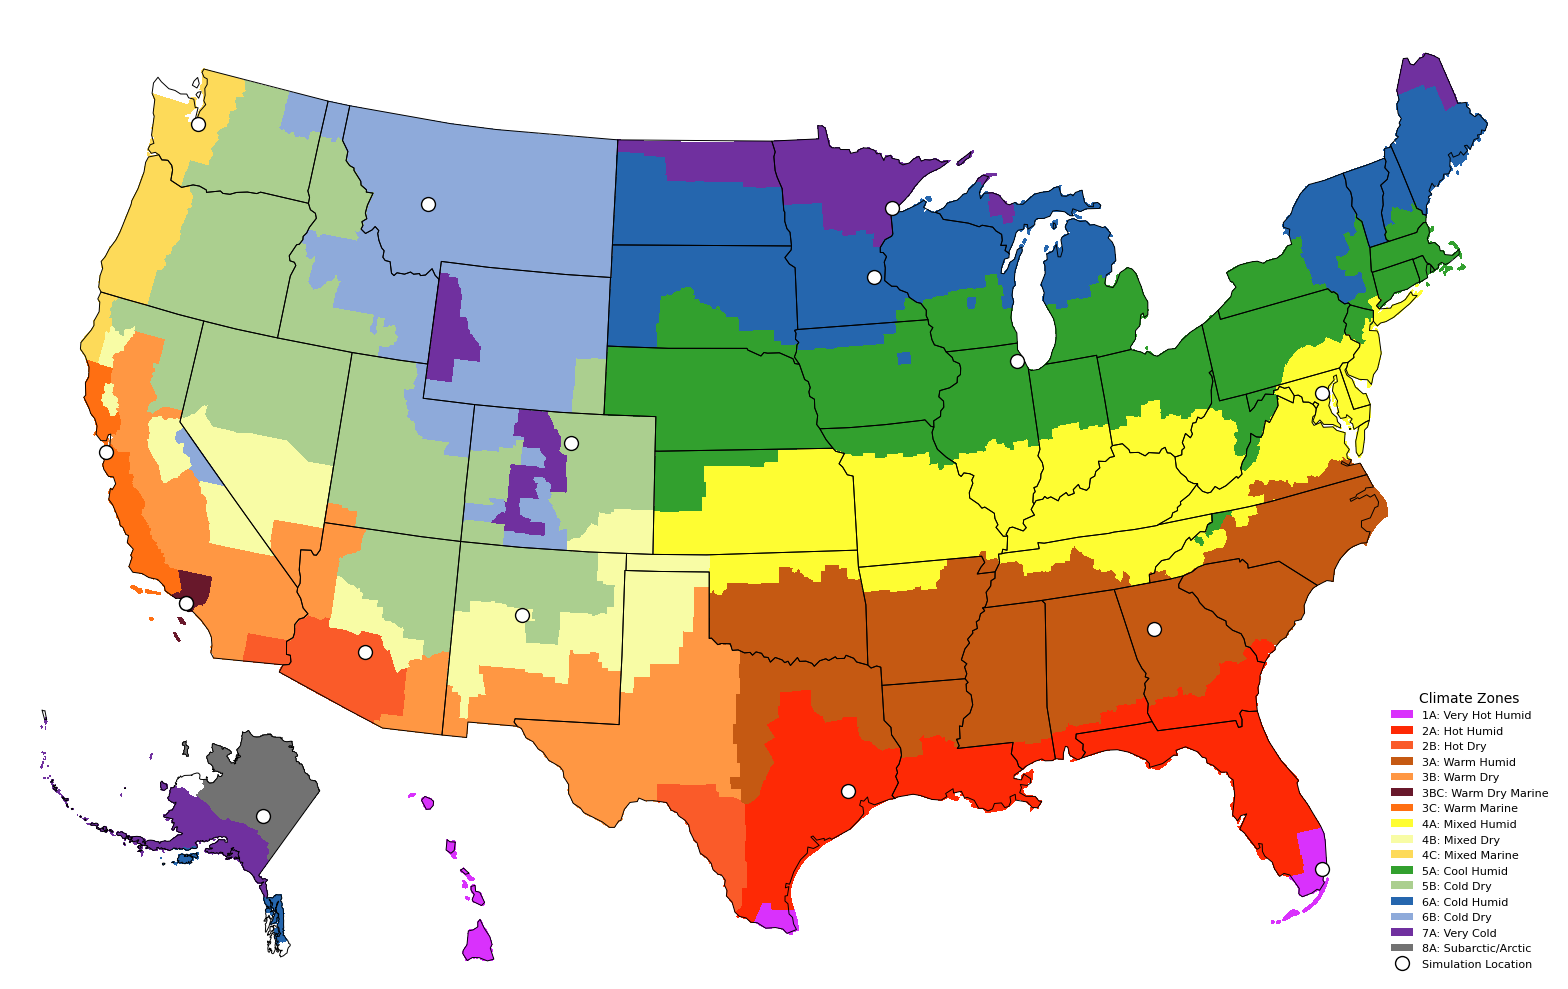

In [13]:


# create an axis with 2 insets − this defines the inset sizes
fig, continental_ax = plt.subplots(figsize=(20, 10))
alaska_ax = continental_ax.inset_axes([.01, .01, .20, .28])
hawaii_ax = continental_ax.inset_axes([.21, .01, .15, .19])

cont = zones[(zones['State']!='Alaska') & (zones['State']!='Hawaii')]
alaska = zones[zones['State']=='Alaska']
hawaii = zones[zones['State']=='Hawaii']

cont.plot(ax=continental_ax, color=cont['cz_color'],
          antialiased=False)
alaska.plot(ax=alaska_ax, color=alaska['cz_color'],
            edgecolor='face', lw=0, antialiased=False,)#, vmin=vmin, vmax=vmax)
hawaii.plot(ax=hawaii_ax, color=hawaii['cz_color'],
            edgecolor='face', lw=0, antialiased=False,)#, vmin=vmin, vmax=vmax)

# remove ticks
for ax in [continental_ax, alaska_ax, hawaii_ax]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)
    

cont_lines = state_lines[(state_lines['name']!='Alaska') & (state_lines['name']!='Hawaii') & (state_lines['name']!='Puerto Rico')]
alaska_line = state_lines[state_lines['name']=='Alaska']
hawaii_line = state_lines[state_lines['name']=='Hawaii']

cont_lines.plot(ax=continental_ax, facecolor="none", edgecolor='black', lw=0.7)
alaska_line.plot(ax=alaska_ax, facecolor="none", edgecolor='black', lw=0.7)
hawaii_line.plot(ax=hawaii_ax, facecolor="none", edgecolor='black', lw=0.7)

# plot_locations
plot_points_a = []
plot_points_b = []
for cz in cz_list:
    if cz=='8a':
        plot_points_b.append(Point(location_dict[cz]))
    else:
        plot_points_a.append(Point(location_dict[cz]))

gpd.GeoSeries(plot_points_a).set_crs('EPSG:4326').to_crs('EPSG:2163').plot(ax = continental_ax, 
                                  markersize = 100, color = 'white', marker = 'o', 
                                  edgecolor='k', lw=1,zorder=3, antialiased=True)

gpd.GeoSeries(plot_points_b).set_crs('EPSG:4326').to_crs('EPSG:2163').plot(ax = alaska_ax, 
                                  markersize = 100, color = 'white', marker = 'o', 
                                  edgecolor='k', lw=1,zorder=3, antialiased=True)

lgd_el_cz = build_lgd([cz_color_dict[cz] for cz in cz_list], 
                   [f'{cz.upper()}: {cz_names[cz]}' for cz in cz_list])
lgd_el_tmy = build_lgd([('white','k')],['Simulation Location'],element_type='marker')
continental_ax.legend(handles=lgd_el_cz+lgd_el_tmy, loc='lower right', frameon=False, title='Climate Zones',
                      fontsize=8)

plt.tight_layout()

plt.savefig('./plots/climate_zones.png',dpi=600)

## GRid Carbon

In [10]:
grid_rgb_list = [(42, 163, 100),
                 (242, 229, 76),
                 (210, 166, 62),
                 (177, 104, 49),
                 (124, 54, 28),
                 (56, 29, 2),
                 (56, 29, 2),
                 (47, 24, 2),
                 (23, 12, 1),
                 (0, 0, 0)]
grid_rgb_list_norm = []
for code in grid_rgb_list:
    grid_rgb_list_norm.append(tuple([e/255 for e in code]))

grid_rgb_list_norm = ['#2ea463',
    '#7eba5a',
    '#a6c756',
    '#dadc4f',
    '#e8d047',
    '#ddbb43',
    '#d2a63e',
    '#c89239',
    '#b67434',
    '#a75f2d',
    '#894222',
    '#703216',
    '#5a2a0c',
    '#432206',
    '#381c03',
    '#110801',
    '#000000']

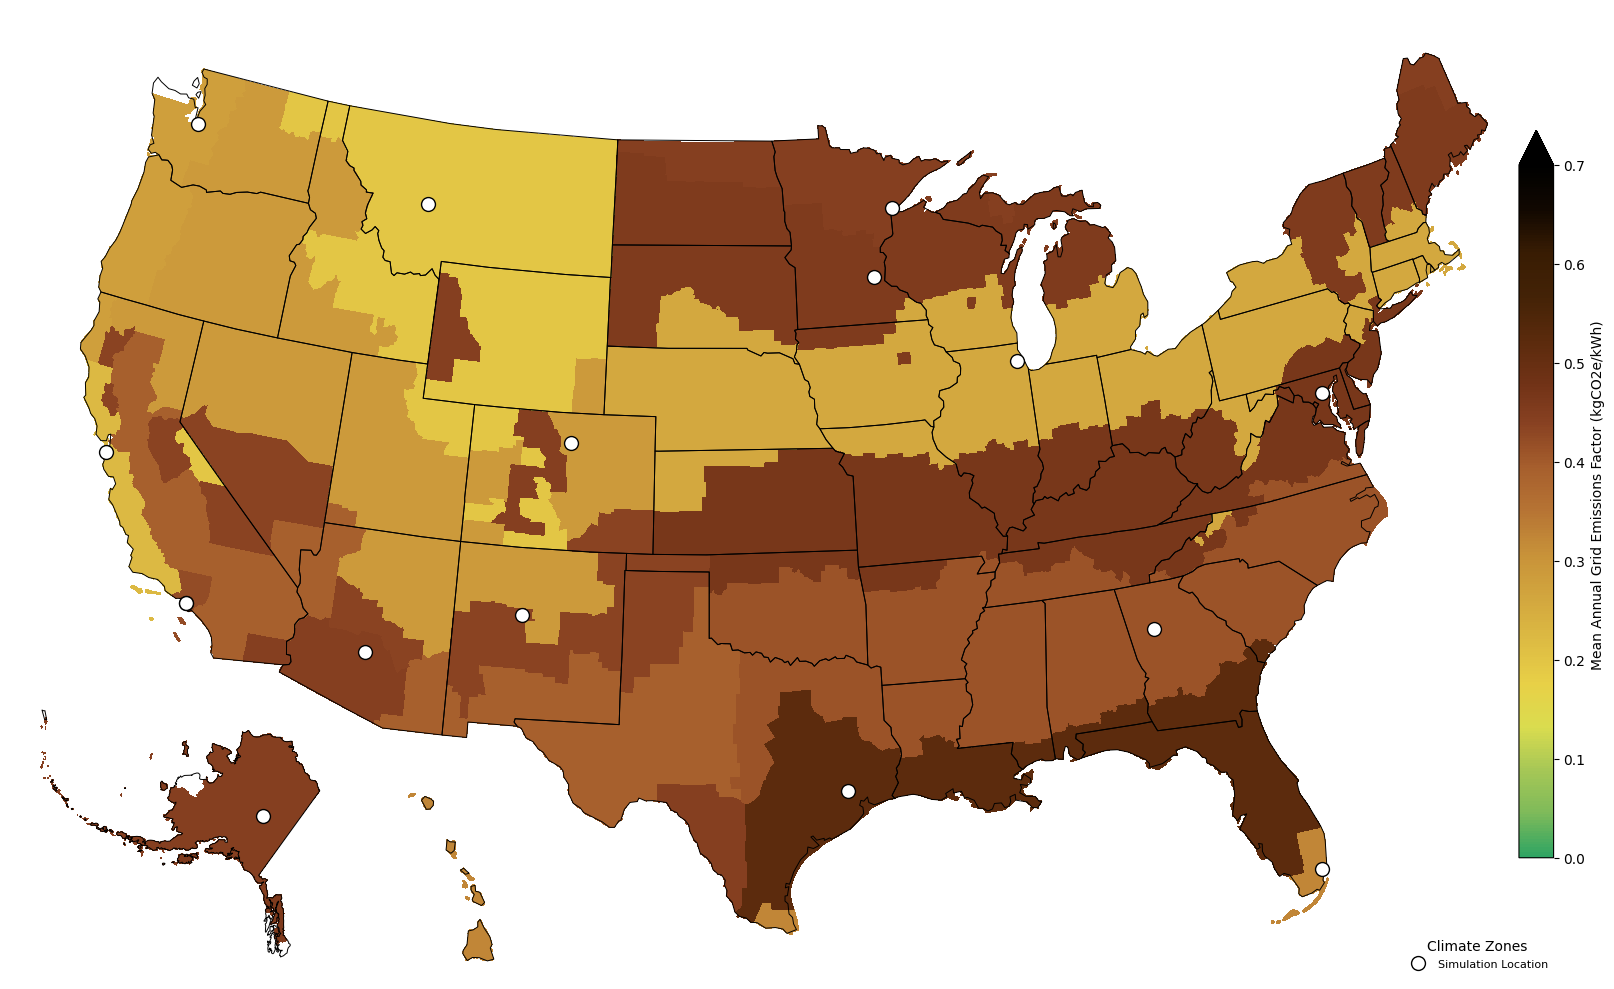

In [12]:

# create an axis with 2 insets − this defines the inset sizes
fig, continental_ax = plt.subplots(figsize=(20, 10))
alaska_ax = continental_ax.inset_axes([.01, .01, .20, .28])
hawaii_ax = continental_ax.inset_axes([.21, .01, .15, .19])

cont = zones[(zones['State']!='Alaska') & (zones['State']!='Hawaii')]
alaska = zones[zones['State']=='Alaska']
hawaii = zones[zones['State']=='Hawaii']

plot_col = 'grid_emissions'
cmap = mpl.colors.LinearSegmentedColormap.from_list(name='emissions_cmap', 
                                                    colors=grid_rgb_list_norm, 
                                                    # N=len(grid_rgb_list_norm)
                                                    )
vmin, vmax = 0, 0.7

cont.plot(column=plot_col, ax=continental_ax,
          edgecolor='lightgray', lw=0, antialiased=False,
          cmap=cmap,vmin=vmin, vmax=vmax, legend=True,
          legend_kwds={'location':'right',
                       'pad':-0.02,
                       'shrink':0.75, 
                       'extend':'max',
                       'spacing':'uniform',
                       'label':'Mean Annual Grid Emissions Factor (kgCO2e/kWh)'
                       }
          )
alaska.plot(column=plot_col, ax=alaska_ax,
            edgecolor='lightgray', lw=0, antialiased=False,
          cmap=cmap,vmin=vmin, vmax=vmax, legend=False)
hawaii.plot(column=plot_col, ax=hawaii_ax,
            edgecolor='lightgray', lw=0, antialiased=False,
          cmap=cmap,vmin=vmin, vmax=vmax, legend=False)

# remove ticks
for ax in [continental_ax, alaska_ax, hawaii_ax]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)
    
cont_lines = state_lines[(state_lines['name']!='Alaska') & (state_lines['name']!='Hawaii') & (state_lines['name']!='Puerto Rico')]
alaska_line = state_lines[state_lines['name']=='Alaska']
hawaii_line = state_lines[state_lines['name']=='Hawaii']

cont_lines.plot(ax=continental_ax, facecolor="none", edgecolor='black', lw=0.7)
alaska_line.plot(ax=alaska_ax, facecolor="none", edgecolor='black', lw=0.7)
hawaii_line.plot(ax=hawaii_ax, facecolor="none", edgecolor='black', lw=0.7)


# plot_locations
plot_points_a = []
plot_points_b = []
for cz in cz_list:
    if cz=='8a':
        plot_points_b.append(Point(location_dict[cz]))
    else:
        plot_points_a.append(Point(location_dict[cz]))

gpd.GeoSeries(plot_points_a).set_crs('EPSG:4326').to_crs('EPSG:2163').plot(ax = continental_ax, 
                                  markersize = 100, color = 'white', marker = 'o', 
                                  edgecolor='k', lw=1,zorder=3, antialiased=True)

gpd.GeoSeries(plot_points_b).set_crs('EPSG:4326').to_crs('EPSG:2163').plot(ax = alaska_ax, 
                                  markersize = 100, color = 'white', marker = 'o', 
                                  edgecolor='k', lw=1,zorder=3, antialiased=True)

lgd_el_tmy = build_lgd([('white','k')],['Simulation Location'],element_type='marker')
continental_ax.legend(handles=lgd_el_tmy, loc='lower right', frameon=False, title='Climate Zones',
                      fontsize=8)

plt.tight_layout()

fig.savefig('./plots/grid_emissions.png',dpi=600)